<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_class_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf

In [2]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [3]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
GPU is NOT AVAILABLE


In [11]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)

In [9]:
def build_emotions():
    return image_dataset_from_directory(
                        f"drive/MyDrive/class_archive",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [29]:
emotions = build_emotions()

# Get the names of the labels
class_names = tuple(emotions.class_names)
print(class_names)

# Print the shape of the images
for image, label in emotions.take(1):
    print(image.shape)

Found 404 files belonging to 7 classes.
('class_angry', 'class_disgusted', 'class_fearful', 'class_happy', 'class_neutral', 'class_sad', 'class_surprised')
(1, 48, 48, 1)


In [17]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

emotions = emotions.map(lambda image, label: (preprocessing_model(image), label))

In [8]:
# Load the model
model = tf.keras.models.load_model('drive/MyDrive/efficientnet_v2_finetuning.keras')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 1024)              25166848  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [18]:
# Predict the labels of the test dataset
y_pred = model.predict(emotions, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(emotions, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

404/404 [==============================] - 38s 71ms/step - loss: 3.2170 - accuracy: 0.3391
Test loss: 3.2170352935791016
Test accuracy: 0.3391089141368866


In [19]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in emotions], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

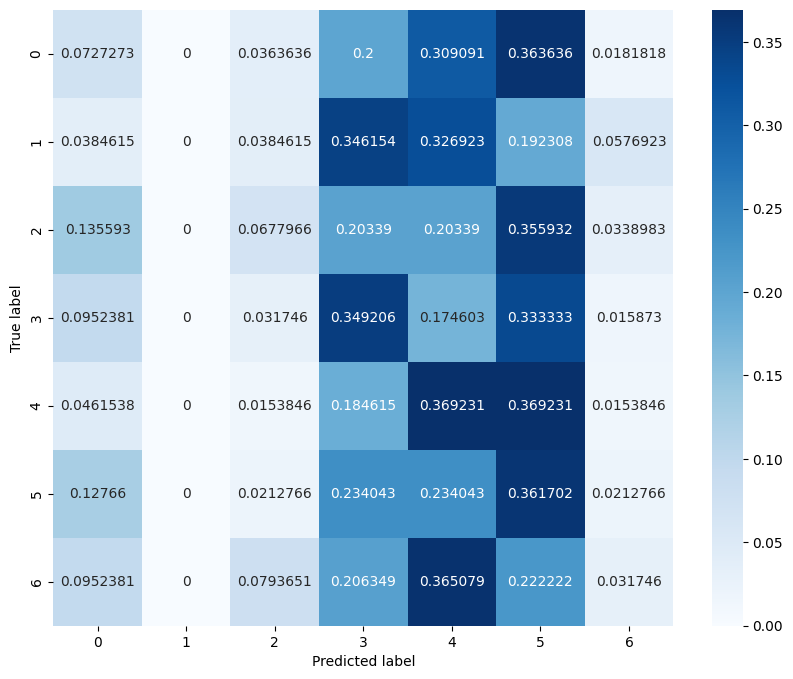

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

1/1 [==============================] - 0s 75ms/step


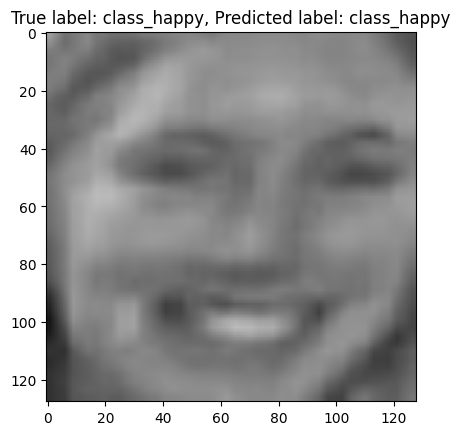

In [27]:
for image, label in emotions.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()